In [3]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)
import numpy as np
print(np.__version__)

from keras_tqdm import TQDMNotebookCallback
# ...fit(verbose = 0, callbacks=[TQDMNotebookCallback()])


from keras.applications.densenet import DenseNet201
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

from keras.optimizers import Adam

2.2.2
1.10.0
1.14.2


In [4]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

74842112/74836368 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________

In [5]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dense(9, activation='softmax'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 17289     
Total params: 18,346,953
Trainable params: 18,114,057
Non-trainable params: 232,896
_________________________________________________________________


In [7]:
# define metric
from balancedAccuracy import balancedAccuracy
num_classes = 9
bacc_metric = balancedAccuracy(num_classes)

In [8]:
# plot_confusion_matrix function
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ["MEL", "NV", "BCC", "AK", "KL", "DF", "VASC", "SCC", "UNK"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(np.mean(np.diag(cm)))
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # get balanced accuracy
    return np.mean(np.diag(cm))
    


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [9]:
data = np.load("AWS-LESIONDATA-2019.npz")

imageList = data["imageList"]
targetList = data["targetList"]
imageValList = data["imageValList"]
targetValList = data["targetValList"]
testList = data["testList"]
targetTestList = data["targetTestList"]

In [10]:
def valMatrix():
    y_test = targetValList.copy()
    y_pred = model.predict(imageValList)
    y_pred = y_pred.argmax(1)
    y_test = y_test.argmax(1)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    print("Balanced Accuracy: "+ str(plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized Validation confusion matrix')))
    plt.show()

def trainMatrix():
    y_test = targetList.copy()
    y_pred = model.predict(imageList)
    y_pred = y_pred.argmax(1)
    y_test = y_test.argmax(1)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    print("Balanced Accuracy: "+ str(plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized Training confusion matrix')))
    plt.show()
    
def testMatrix():
    y_test = targetTestList.copy()
    y_pred = model.predict(testList)
    y_pred = y_pred.argmax(1)
    y_test = y_test.argmax(1)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    print("Balanced Accuracy: "+ str(plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized Training confusion matrix')))
    plt.show()

In [11]:
# get sample weights for training (class_weight doesn't work with one-hot encoding)
weight_dict = {0:5.6050885 ,   1:1.96776699,   2:7.61954887,  3:29.28901734,
         4:9.65142857, 5:105.5625,  6:99.35294118,  7:40.21428571,
                8:0}
temp = targetList.argmax(1)
sample_weights = np.array(list(map(weight_dict.get, temp)))

# get sample weights for validation
temp = targetValList.argmax(1)
sample_weights_val = np.array(list(map(weight_dict.get, temp)))

In [12]:
from keras.applications.densenet import preprocess_input
imageList = preprocess_input(imageList)
imageValList = preprocess_input(imageValList)
testList = preprocess_input(testList)

In [13]:
import json

In [14]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
              metrics=[bacc_metric.balanced_acc])
historyfile = model.fit(imageList, targetList, batch_size=32, epochs=3, verbose=0,
          sample_weight=sample_weights,
          validation_data=(imageValList, targetValList, sample_weights_val), initial_epoch=0,
          callbacks = [TQDMNotebookCallback(leave_inner=True)])


In [20]:
model.fit(imageList, targetList, batch_size=32, epochs=3, verbose=0,
          sample_weight=sample_weights,
          validation_data=(imageValList, targetValList, sample_weights_val), initial_epoch=0,
          callbacks = [TQDMNotebookCallback(leave_inner=True)])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-55d3580897fb>", line 4, in <module>
    callbacks = [TQDMNotebookCallback(leave_inner=True)])
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py", line 1037, in fit
    validation_steps=validation_steps)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2666, in __call__
    return self._call(inputs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2636, in _call
    fetched = self._calla

KeyboardInterrupt: 

In [ ]:
model.save("dnet201-inet-3ep")

Normalized confusion matrix
0.6440876931594017
Balanced Accuracy: 0.6440876931594017


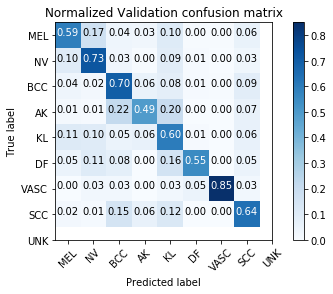

In [15]:
valMatrix()

Normalized confusion matrix
0.6405529822724625
Balanced Accuracy: 0.6405529822724625


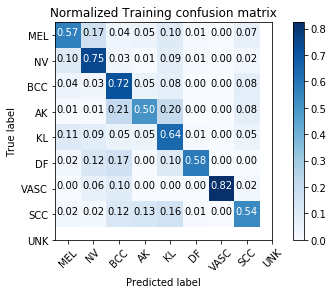

In [16]:
testMatrix()

In [ ]:
# TEMP
from keras.models import load_model
model = load_model('/vol30/resnet-final/checkpoint1',
                   custom_objects={'balanced_acc': bacc_metric.balanced_acc})